# **1. Import Library**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import json
import kagglehub
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from tensorflow.keras.optimizers import Adam





# **2. Memuat Dataset**

In [5]:
path = kagglehub.dataset_download("nphantawee/pump-sensor-data")



Using Colab cache for faster access to the 'pump-sensor-data' dataset.


In [6]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pump-sensor-data


In [7]:

csv_path = os.path.join(path, "sensor.csv")
data_sensor = pd.read_csv(csv_path)

data_sensor.head()


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


# **3. Data Preprocessing**

In [8]:
print(data_sensor.columns)
print(data_sensor['machine_status'].value_counts())


Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')
machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


In [9]:
data_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [10]:
data_sensor['timestamp'] = pd.to_datetime(data_sensor['timestamp'])

In [11]:
label_map = {
    'NORMAL': 0,
    'RECOVERING': 1,
    'BROKEN': 1
}

data_sensor['label'] = data_sensor['machine_status'].map(label_map)


In [12]:
data_sensor['label'].value_counts()


,count
label,
0,205836
1,14484


In [13]:
data_sensor.label.value_counts()

,count
label,
0,205836
1,14484


In [14]:
data_sensor.describe()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,label
count,220320.000000,220320,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000,220320.000000
mean,110159.500000,2018-06-16 11:59:29.999999488,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,...,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667,0.065741
min,0.000000,2018-04-01 00:00:00,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,...,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779,0.000000
25%,55079.750000,2018-05-09 05:59:45,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,...,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800,0.000000
50%,110159.500000,2018-06-16 11:59:30,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,...,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000,0.000000
75%,165239.250000,2018-07-24 17:59:15,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,...,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500,0.000000
max,220319.000000,2018-08-31 23:59:00,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,...,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000,1.000000
std,63601.049991,NaN,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,...,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607,0.247829


/tmp/ipython-input-2646401192.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data_sensor, palette=palette_colors)


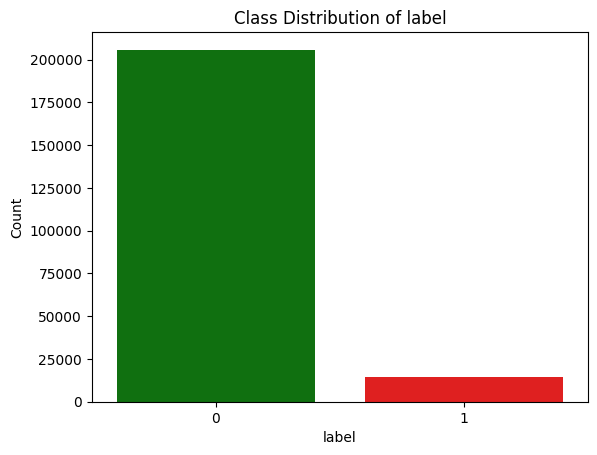

In [15]:
palette_colors = {"0": "green", "1": "red",}
sns.countplot(x='label', data=data_sensor, palette=palette_colors)
plt.title('Class Distribution of label')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

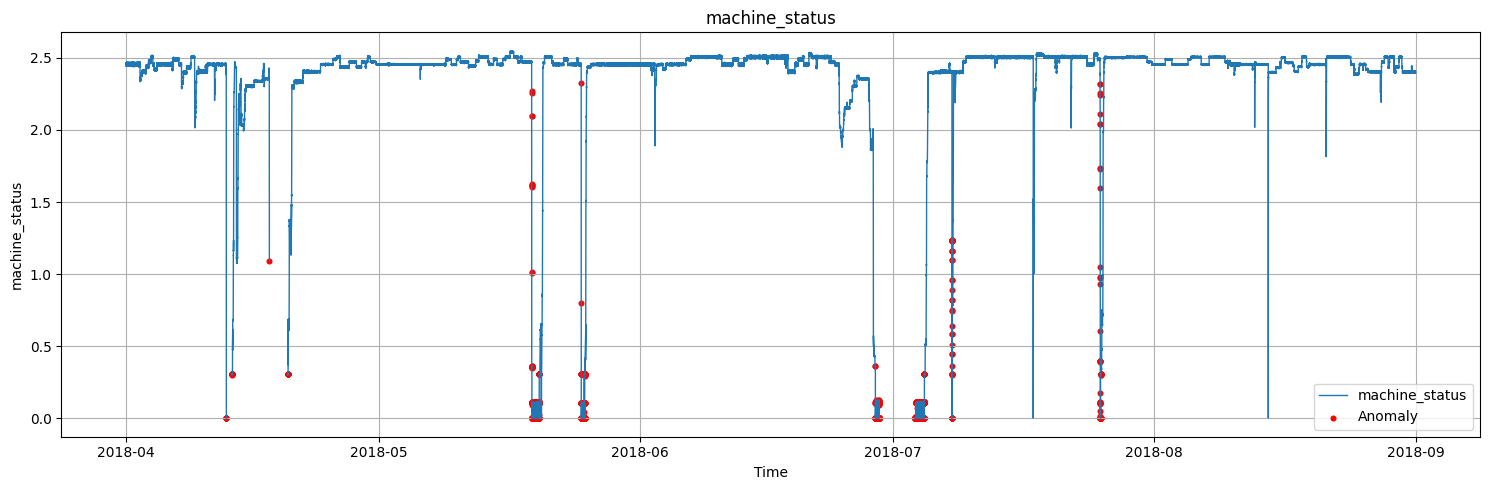

In [16]:
plt.figure(figsize=(15,5))


plt.plot(
    data_sensor['timestamp'],
    data_sensor['sensor_00'],
    label='machine_status',
    linewidth=1
)


anomaly_points = data_sensor[data_sensor['label'] == 1]
plt.scatter(
    anomaly_points['timestamp'],
    anomaly_points['sensor_00'],
    color='red',
    label='Anomaly',
    s=11
)

plt.title("machine_status")
plt.xlabel("Time")
plt.ylabel("machine_status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


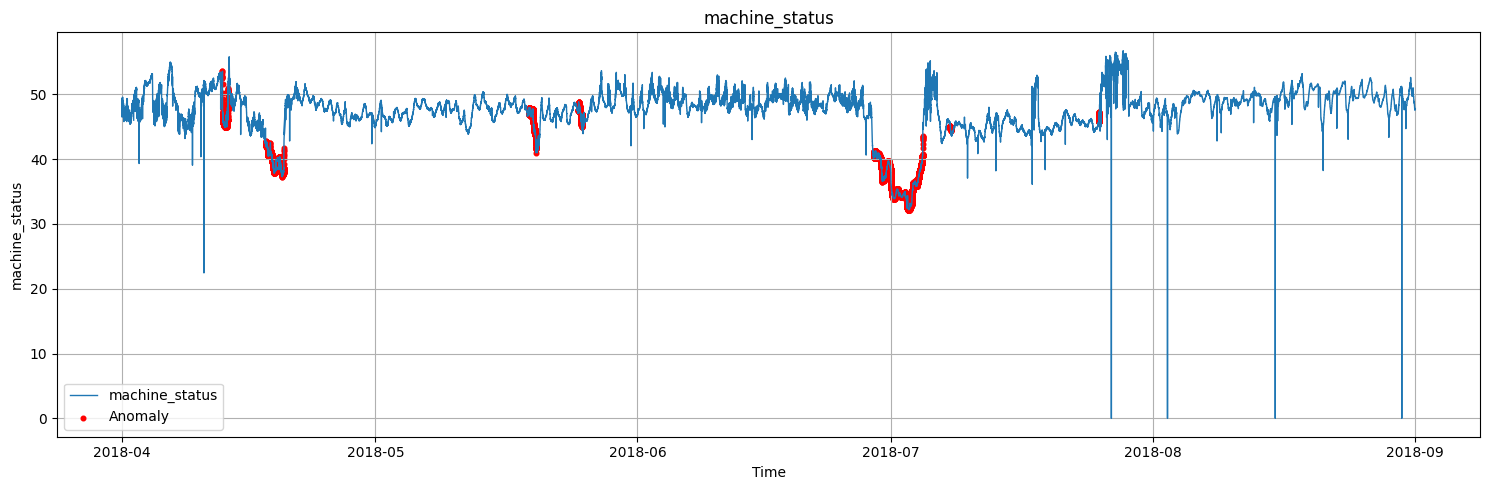

In [17]:

plt.figure(figsize=(15,5))


plt.plot(
    data_sensor['timestamp'],
    data_sensor['sensor_01'],
    label='machine_status',
    linewidth=1
)


anomaly_points = data_sensor[data_sensor['label'] == 1]
plt.scatter(
    anomaly_points['timestamp'],
    anomaly_points['sensor_01'],
    color='red',
    label='Anomaly',
    s=11
)

plt.title("machine_status")
plt.xlabel("Time")
plt.ylabel("machine_status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


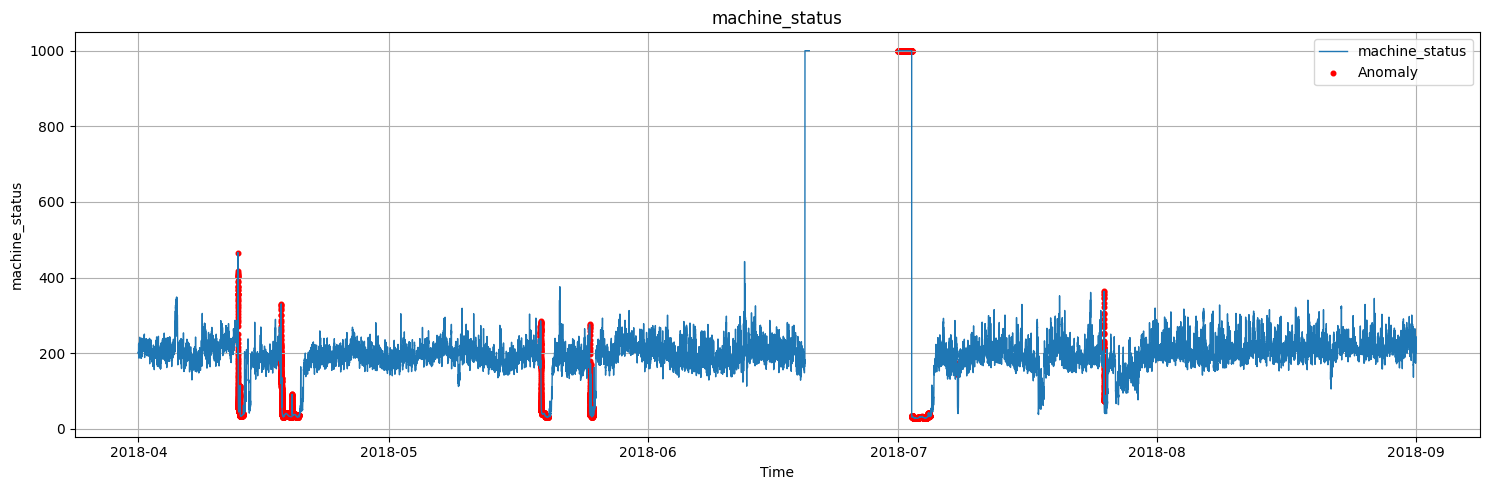

In [18]:

plt.figure(figsize=(15,5))

plt.plot(
    data_sensor['timestamp'],
    data_sensor['sensor_51'],
    label='machine_status',
    linewidth=1
)


anomaly_points = data_sensor[data_sensor['label'] == 1]
plt.scatter(
    anomaly_points['timestamp'],
    anomaly_points['sensor_51'],
    color='red',
    label='Anomaly',
    s=11
)

plt.title("machine_status")
plt.xlabel("Time")
plt.ylabel("machine_status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
print(data_sensor.columns)


Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status',
       'label'],
      dtype='object')


In [20]:
print("Shape of data:", data_sensor.shape)

Shape of data: (220320, 56)


In [21]:
print(data_sensor['label'].value_counts(normalize=True))

label
0    0.934259
1    0.065741
Name: proportion, dtype: float64


In [22]:
print("Missing values per column:\n", data_sensor.isnull().sum())

Missing values per column:
 Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             

In [23]:
data_sensor = data_sensor.drop(columns=['sensor_15'])

In [24]:
data_sensor = data_sensor.dropna()


In [25]:
print("Missing values per column:\n", data_sensor.isnull().sum())

Missing values per column:
 Unnamed: 0        0
timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47   

In [26]:
print("Number of duplicates:", data_sensor.duplicated().sum())

Number of duplicates: 0


In [27]:
sensor_cols = [c for c in data_sensor.columns if c.startswith("sensor_")]
X_raw = data_sensor[sensor_cols].values
y_raw = data_sensor['label'].values


# **4. Sliding Window**

In [28]:

WINDOW_SIZE = 30
STRIDE = 1

def sliding_window_multivariate(X, y, window_size, stride=1, anomaly_ratio=0.2):
    X_windows, y_windows = [], []

    for i in range(0, len(X) - window_size + 1, stride):
        window_X = X[i:i+window_size]
        window_y = y[i:i+window_size]

        # window anomali jika ≥20% titik anomali
        label = 1 if window_y.mean() >= anomaly_ratio else 0

        X_windows.append(window_X)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

X, y = sliding_window_multivariate(
    X_raw, y_raw,
    window_size=30,
    stride=1,
    anomaly_ratio=0.2
)


print("X:", X.shape)
print("y:", y.shape)


X: (119074, 30, 51)
y: (119074,)


# **5. Data Splitting**

In [29]:
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (83351, 30, 51)
Val  : (17861, 30, 51)
Test : (17862, 30, 51)


In [30]:
print("Jumlah anomali di val:", y_val.sum())
print("Total val sample:", len(y_val))


Jumlah anomali di val: 0
Total val sample: 17861


# **6. Normalisasi**

In [31]:

scaler = MinMaxScaler()


X_train_r = X_train.reshape(-1, X_train.shape[-1])
X_val_r   = X_val.reshape(-1, X_val.shape[-1])
X_test_r  = X_test.reshape(-1, X_test.shape[-1])

scaler.fit(X_train_r)

X_train = scaler.transform(X_train_r).reshape(X_train.shape)
X_val   = scaler.transform(X_val_r).reshape(X_val.shape)
X_test  = scaler.transform(X_test_r).reshape(X_test.shape)


In [ ]:
print(f"Min nilai data training : {X_train.min()}")
print(f"Max nilai data training : {X_train.max()}")

print(f"Min nilai data validation : {X_test.min()}")
print(f"Max nilai data validation : {X_test.max()}")

print(f"Min nilai data testing : {X_val.min()}")
print(f"Max nilai data testing : {X_val.max()}")

Min nilai data training : 0.0
Max nilai data training : 1.0000000000000002
Min nilai data validation : -0.19239931766576968
Max nilai data validation : 2.3144435519581634
Min nilai data testing : 0.0
Max nilai data testing : 1.104108928937644


In [ ]:
print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)


X_train: (83351, 30, 51)
X_val  : (17861, 30, 51)
X_test : (17862, 30, 51)


# **7. Membangun Model Hybrid CNN-LSTM**


In [ ]:
model = Sequential([

    Conv1D(64, 3, activation='relu', padding='same',
           kernel_regularizer=l2(1e-4),
           input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    LSTM(
        64,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.2,
        recurrent_dropout=0.2,
        return_sequences=False,
        kernel_regularizer=l2(1e-4)
    ),


    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,961 (347.50 KB)

 Trainable params: 88,577 (346.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "cnn_lstm_best.keras",
    monitor='val_loss',
    save_best_only=True
)


In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.5089329327862446), 1: np.float64(28.48632946001367)}


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.9720 - loss: 0.1234 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 2/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9885 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 3/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9863 - loss: 0.0568 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 4/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9896 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 5/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.9908 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 6/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.9880 - loss: 0.0416 - val_accuracy: 0.9993 - val_loss: 0.0178
Epoch 7/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9919 - loss: 0.0388 - val_accuracy: 0.9971 - val_loss: 0.0248
Epoch 8/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.9927 -

### Evaluasi Model

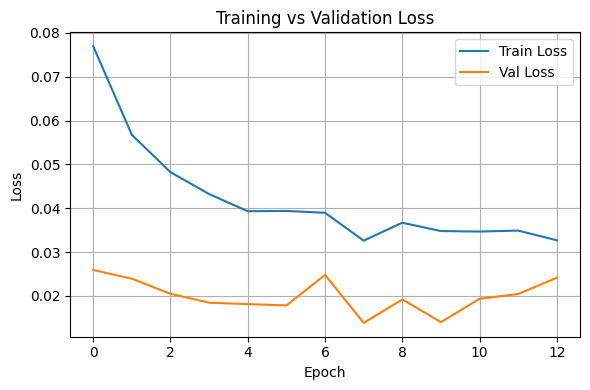

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


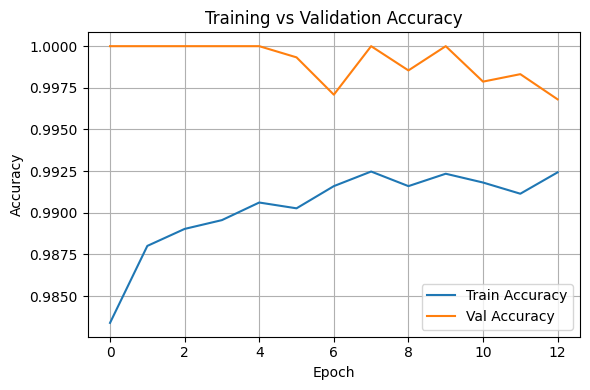

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss     : {results[0]:.4f}")
print(f"Test Accuracy : {results[1]:.4f}")


Test Loss     : 0.2062
Test Accuracy : 0.9223


In [ ]:


y_pred_prob = model.predict(X_test)


THRESHOLD = 0.5
y_pred = (y_pred_prob >= THRESHOLD).astype(int).ravel()


559/559 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


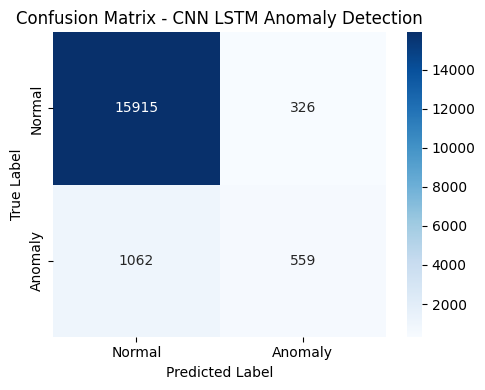

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Anomaly'],
    yticklabels=['Normal', 'Anomaly']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN LSTM Anomaly Detection")
plt.tight_layout()
plt.show()


In [ ]:

y_prob = model.predict(X_test).ravel()

THRESHOLD = 0.5

y_pred = (y_prob >= THRESHOLD).astype(int)

559/559 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:

print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Normal", "Anomaly"],
        digits=4
    )
)


              precision    recall  f1-score   support

      Normal     0.9374    0.9799    0.9582     16241
     Anomaly     0.6316    0.3448    0.4461      1621

    accuracy                         0.9223     17862
   macro avg     0.7845    0.6624    0.7022     17862
weighted avg     0.9097    0.9223    0.9117     17862



In [ ]:
y_test_proba = model.predict(X_test).ravel()


559/559 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [ ]:

roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.9845


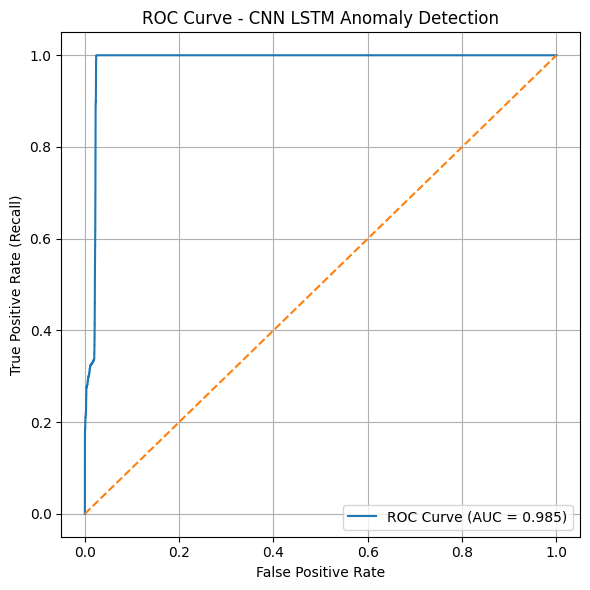

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - CNN LSTM Anomaly Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# **8. Hyperparameter tuning dengan RANDOM SEARCH**





In [ ]:
!pip install -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:

kt.RandomSearch


keras_tuner.src.tuners.randomsearch.RandomSearch

In [ ]:

def build_model(hp):
    model = Sequential()

    # ===== CNN Block 1 =====
    model.add(
        Conv1D(
            filters=hp.Choice('filters_1', [64], default=64),
            kernel_size=hp.Choice('kernel_1', [3], default=3),
            activation='relu',
            padding='same',
            kernel_regularizer=l2(
                hp.Choice('l2_1', [1e-4], default=1e-4)
            ),
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(
        hp.Float('dropout_1', 0.2, 0.5, step=0.1, default=0.3)
    ))

    # ===== CNN Block 2 =====
    model.add(
        Conv1D(
            filters=hp.Choice('filters_2', [128], default=128),
            kernel_size=hp.Choice('kernel_2', [3], default=3),
            activation='relu',
            padding='same',
            kernel_regularizer=l2(
                hp.Choice('l2_2', [1e-4], default=1e-4)
            )
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(
        hp.Float('dropout_2', 0.2, 0.5, step=0.1, default=0.3)
    ))

    # ===== LSTM =====
    model.add(
        LSTM(
            units=hp.Choice('lstm_units', [64], default=64),
            activation="tanh",
            recurrent_activation="sigmoid",
            dropout=hp.Float('dropout_lstm', 0.2, 0.5, step=0.1, default=0.2),
            recurrent_dropout=0.2,
            return_sequences=False,
            kernel_regularizer=l2(
                hp.Choice('l2_lstm', [1e-4], default=1e-4)
            )
        )
    )
    model.add(Dropout(0.3))

    # ===== Dense =====
    model.add(
        Dense(
            hp.Choice('dense_units', [64], default=64),
            activation='relu'
        )
    )
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))


    lr = hp.Choice("learning_rate", [1e-4, 3e-4, 1e-3], default=1e-3)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=5,
    executions_per_trial=1,
    directory="tuning",
    project_name="cnn_lstm_anomaly"
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]
)

Trial 5 Complete [00h 17m 32s]
val_loss: 0.004912939388304949

Best val_loss So Far: 0.002431810600683093
Total elapsed time: 01h 32m 54s


### Evaluasi model Hyperparameter tuning

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,961 (347.50 KB)

 Trainable params: 88,577 (346.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
test_results = best_model.evaluate(X_test, y_test, verbose=0)

for name, val in zip(best_model.metrics_names, test_results):
    print(f"{name}: {val:.4f}")


loss: 0.3683
compile_metrics: 0.9094


In [ ]:
y_prob = best_model.predict(X_test).ravel()


559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [ ]:
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)


In [ ]:

threshold = np.percentile(y_prob, 95)
y_pred = (y_prob >= threshold).astype(int)


In [ ]:

print(classification_report(
    y_test, y_pred,
    target_names=["Normal", "Anomaly"]
))


              precision    recall  f1-score   support

      Normal       0.93      0.98      0.95     16241
     Anomaly       0.55      0.30      0.39      1621

    accuracy                           0.91     17862
   macro avg       0.74      0.64      0.67     17862
weighted avg       0.90      0.91      0.90     17862



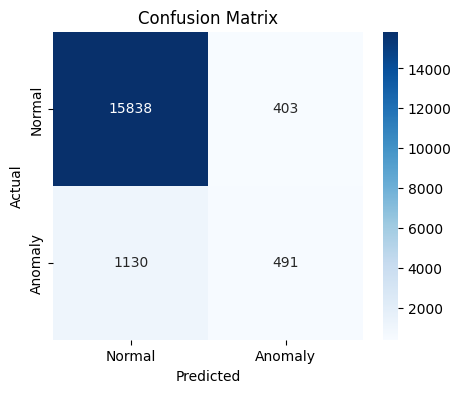

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Anomaly"],
    yticklabels=["Normal", "Anomaly"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


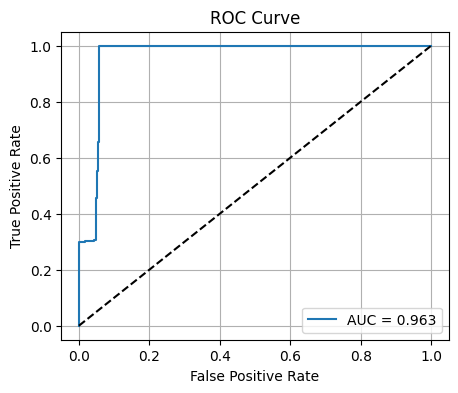

In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


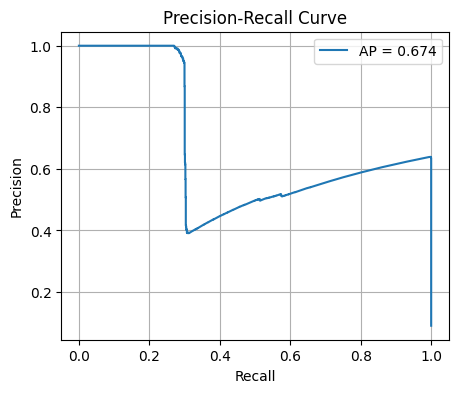

In [ ]:

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()



# **9. Membangun Model SVM**


In [ ]:

X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_val_svm   = X_val.reshape(X_val.shape[0], -1)
X_test_svm  = X_test.reshape(X_test.shape[0], -1)


In [ ]:

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced'
)

svm_model.fit(X_train_svm, y_train)


SVC(class_weight='balanced')

### Evaluasi Model SVM

In [ ]:

y_pred_svm = svm_model.predict(X_test_svm)

print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


=== SVM Classification Report ===
              precision    recall  f1-score   support

           0     0.9979    0.9380    0.9670     16241
           1     0.6121    0.9803    0.7536      1621

    accuracy                         0.9418     17862
   macro avg     0.8050    0.9591    0.8603     17862
weighted avg     0.9629    0.9418    0.9477     17862

Confusion Matrix:
[[15234  1007]
 [   32  1589]]


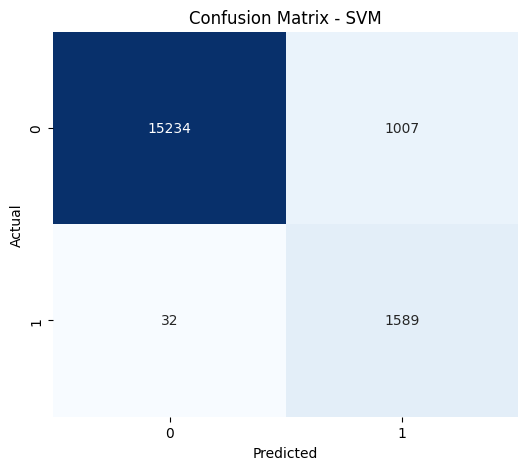

=== SVM Classification Report ===
              precision    recall  f1-score   support

           0     0.9979    0.9380    0.9670     16241
           1     0.6121    0.9803    0.7536      1621

    accuracy                         0.9418     17862
   macro avg     0.8050    0.9591    0.8603     17862
weighted avg     0.9629    0.9418    0.9477     17862



In [ ]:

y_pred_svm = svm_model.predict(X_test_svm)


cm = confusion_matrix(y_test, y_pred_svm)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()


print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, digits=4))


ROC-AUC Score (SVM): 0.9835


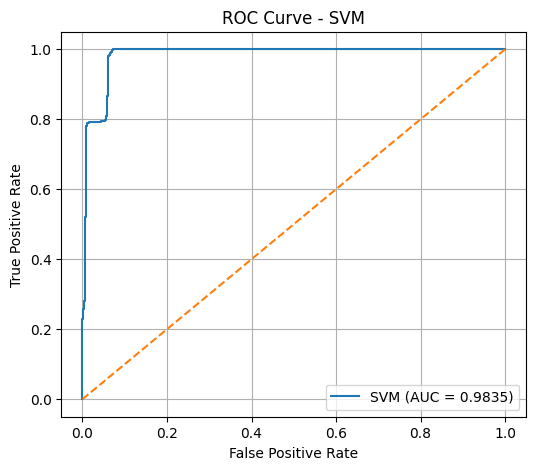

In [ ]:


y_score = svm_model.decision_function(X_test_svm)


fpr, tpr, thresholds = roc_curve(y_test, y_score)


roc_auc = auc(fpr, tpr)

print(f"ROC-AUC Score (SVM): {roc_auc:.4f}")


plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# **10. Membangun Model Random Forest**


In [ ]:
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_val_rf   = X_val.reshape(X_val.shape[0], -1)
X_test_rf  = X_test.reshape(X_test.shape[0], -1)


In [ ]:

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

### Evaluasi Model Random Forest

In [ ]:

y_pred_rf = rf_model.predict(X_test_rf)

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0     0.9091    0.9942    0.9498     16241
           1     0.0693    0.0043    0.0081      1621

    accuracy                         0.9044     17862
   macro avg     0.4892    0.4993    0.4789     17862
weighted avg     0.8329    0.9044    0.8643     17862

Confusion Matrix:
[[16147    94]
 [ 1614     7]]


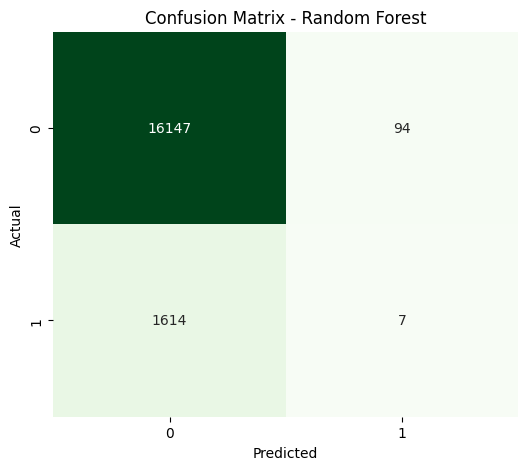

In [ ]:

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


ROC-AUC Score (Random Forest): 0.9926


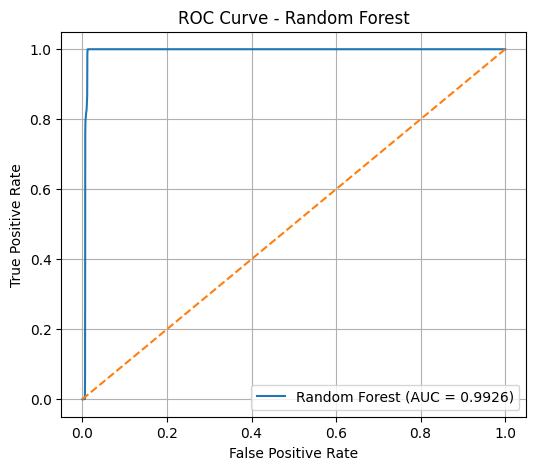

In [ ]:


y_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]


roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f"ROC-AUC Score (Random Forest): {roc_auc:.4f}")


fpr, tpr, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



# **12. Perbandingan Model Hybrid CNN-LSTM, SVM dan Random Forest**


In [ ]:

y_proba_dl = model.predict(X_test).ravel()
y_score_svm = svm_model.decision_function(X_test_svm)
y_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]


559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


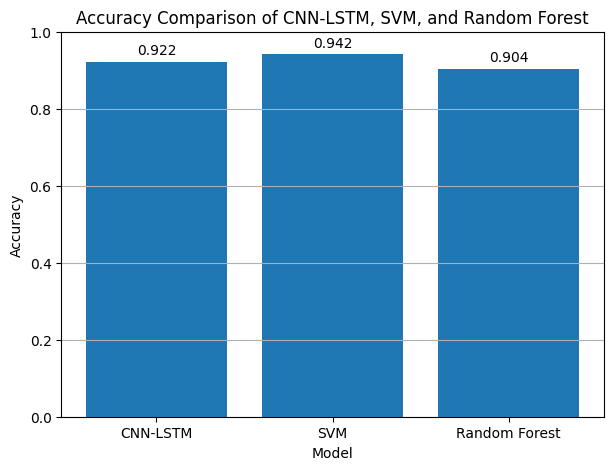

In [ ]:
plt.figure(figsize=(7,5))

bars = plt.bar(df_results["Model"], df_results["Accuracy"])


for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.01,
        f"{yval:.3f}",
        ha='center',
        va='bottom'
    )

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of CNN-LSTM, SVM, and Random Forest")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()



# **13. Eksport model**


In [ ]:
model.save("cnn_lstm_anomaly.h5")


In [ ]:

model.export('saved_model/')


Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 51), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137279785743952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785744912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785745872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785745680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785744528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772688656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785743184: Tensor

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open("saved_model/model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpo3crrl5v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 51), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137279785743952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785744912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785745872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785745680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785744528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772688656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279772689808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279785743184: Te

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input:", input_details)
print("Output:", output_details)


Input: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 30, 51], dtype=int32), 'shape_signature': array([-1, 30, 51], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 64, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
!zip -r saved_model.zip saved_model/


  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 68%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/model.tflite (deflated 10%)
  adding: saved_model/saved_model.pb (deflated 88%)
  adding: saved_model/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

with open('scaler_2.pkl', 'wb') as file:
    pickle.dump(scaler, file)


Demo Model Masih Proses


# **14. Demo Model**


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib


In [2]:

interpreter = tf.lite.Interpreter(
    model_path="model.tflite"
)
interpreter.allocate_tensors()


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


scaler = joblib.load("scaler_2.pkl")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [3]:
def create_sliding_window(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X, dtype=np.float32)


In [4]:
df = pd.read_csv("sensor.csv")

df = df.drop(columns=["timestamp", "machine_status","sensor_15"])
df = df.iloc[:, 1:]
data_new = df.values
data_scaled = scaler.transform(data_new)


In [5]:
WINDOW_SIZE = 30

X_infer = create_sliding_window(data_scaled, WINDOW_SIZE)

print("Shape input:", X_infer.shape)


Shape input: (220290, 30, 51)


In [6]:
predictions = []

for i in range(len(X_infer)):
    input_data = np.expand_dims(X_infer[i], axis=0)

    interpreter.set_tensor(
        input_details[0]['index'],
        input_data
    )

    interpreter.invoke()

    output = interpreter.get_tensor(
        output_details[0]['index']
    )

    predictions.append(output[0][0])

predictions = np.array(predictions)


In [7]:
threshold = 0.5

labels = (predictions > threshold).astype(int)

results = pd.DataFrame({
    "Probability": predictions,
    "Label": labels
})

results["Status"] = results["Label"].map({
    0: "Normal",
    1: "Anomali"
})

results.head()


,Probability,Label,Status
0,9.401855e-07,0,Normal
1,1.004856e-06,0,Normal
2,1.083329e-06,0,Normal
3,1.150956e-06,0,Normal
4,1.240951e-06,0,Normal


In [9]:
def predict_tflite_single_window(sensor_window):
    """
    sensor_window shape: (window_size, num_features)
    """
    sensor_window = scaler.transform(sensor_window)
    sensor_window = sensor_window.astype(np.float32)
    sensor_window = np.expand_dims(sensor_window, axis=0)

    interpreter.set_tensor(
        input_details[0]['index'],
        sensor_window
    )
    interpreter.invoke()

    prob = interpreter.get_tensor(
        output_details[0]['index']
    )[0][0]

    status = "Anomali" if prob > 0.5 else "Normal"
    return prob, status


In [20]:
prob, status = predict_tflite_single_window(data_new[:30])
print(prob, status)


9.401855e-07 Normal


In [21]:
sensor_window = X_infer[0]


In [22]:
sensor_window_anomali = sensor_window.copy()
sensor_window_anomali[:, 0] *= 10

prob, status = predict_tflite_single_window(sensor_window_anomali)
print(prob, status)


0.7049232 Anomali
